In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import numpy as np
from utils.preprocessing_util import *
from utils.encoder_lib import *
from pandas import DataFrame
from pprint import pprint

In [15]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [16]:
# Load Datasets

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [17]:
def preprocess_location_property_attributes(df:DataFrame, target_encoder_wrapper:TargetEncoderWrapper, is_training:bool) -> DataFrame :
    _df = df.copy()
    # Drop columns with no significance
    _df = _df.drop('furnished', axis=1)
    _df = _df.drop('elevation', axis=1)

    # Numeric encoding
    _df['flat_type'] = search_and_replace(_df, 'flat_type', '2', 2)
    _df['flat_type'] = search_and_replace(_df, 'flat_type', '3', 3)
    _df['flat_type'] = search_and_replace(_df, 'flat_type', '4', 4)
    _df['flat_type'] = search_and_replace(_df, 'flat_type', '5', 5)
    _df['flat_type'] = search_and_replace(_df, 'flat_type', 'executive', 6)

    # Target encoding
    if is_training:
        _df = target_encoder_wrapper.fit_transform(_df) 
    else:    
        _df = target_encoder_wrapper.transform(_df) 
    
    # OnehotEnoding
    _df = pd.concat([generate_dummies(_df, 'town'),
               _df,
          ], axis=1)

    return _df

def preprocess_rent_date(df:DataFrame) -> DataFrame :
    _df =df.copy()

    # rent year and month
    _df['rent_approval_year'] = pd.to_datetime(_df['rent_approval_date']).dt.year
    _df['rent_approval_month'] = pd.to_datetime(_df['rent_approval_date']).dt.month

    # age of house when rental begin
    _df['age_at_rental_start'] = _df['rent_approval_year'] - _df['lease_commence_date']
    
    _df = _df.drop(columns=['rent_approval_date','lease_commence_date'])
    return _df

def preprocess_geographic_location(df:DataFrame) -> DataFrame :
    _df =df.copy()
    mrt_exist_df = pd.read_csv('../auxiliary-data/sg-mrt-existing-stations.csv')
    mrt_planned_df = pd.read_csv('../auxiliary-data/sg-mrt-planned-stations.csv')
    primary_school_df = pd.read_csv('../auxiliary-data/sg-primary-schools.csv')
    # Calculate distances for each row in df
    _df['dist_mrt_exist'] = _df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], mrt_exist_df), axis=1)
    _df['dist_mrt_planned'] = _df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], mrt_planned_df), axis=1)
    _df['dist_primary_school'] = _df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], primary_school_df), axis=1)
    return _df

def preprocess_subzone_planning_area_region(df:DataFrame) -> DataFrame :
    _df =df.copy()
    return _df

def preprocess_others1(df:DataFrame) -> DataFrame :
    _df =df.copy()
    return _df

def remove_columns(df:DataFrame) -> DataFrame :
    _df =df.copy()
    return _df

def preprocess(df:DataFrame, target_encoder_wrapper:TargetEncoderWrapper, is_training:bool) -> DataFrame:
    _df = df.copy()

    # Proprocess property location attributes
    _df = preprocess_location_property_attributes(_df, target_encoder_wrapper, is_training)

    # Process rent approval date data
    _df = preprocess_rent_date(_df)

    _df=preprocess_geographic_location(_df)

    _df=preprocess_subzone_planning_area_region(_df)

    _df=preprocess_others1(_df)

    _df=remove_columns(_df)

    return _df

In [18]:
# geographic calc take 1min10s+
target_encoder_wrapper = TargetEncoderWrapper(feature_col='flat_model', target_col='monthly_rent', smoothing=10)
df = preprocess(train, target_encoder_wrapper, is_training=True)

In [19]:
X_train = df.drop(columns=['street_name','block','town','region','planning_area','subzone','latitude','longitude','monthly_rent'])
y_train = df['monthly_rent']
X_train.head(100)

,town_bedok,town_bishan,town_bukit batok,town_bukit merah,town_bukit panjang,town_bukit timah,town_central,town_choa chu kang,town_clementi,town_geylang,...,town_yishun,flat_type,flat_model,floor_area_sqm,rent_approval_year,rent_approval_month,age_at_rental_start,dist_mrt_exist,dist_mrt_planned,dist_primary_school
0,False,False,False,False,False,False,False,False,False,False,...,False,3,2370,67.0,2021,9,38,0.006289,0.006071,0.003012
1,True,False,False,False,False,False,False,False,False,False,...,False,4,2370,92.0,2022,5,44,0.008087,0.008135,0.005466
2,False,False,False,False,False,False,False,False,False,False,...,False,3,2636,67.0,2022,10,51,0.001966,0.010649,0.003830
3,False,False,False,False,False,False,False,False,False,False,...,False,6,2879,149.0,2021,8,28,0.013908,0.004643,0.005081
4,False,False,False,False,False,False,False,False,False,False,...,False,3,2636,68.0,2022,11,50,0.001690,0.025345,0.002444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,False,False,False,False,False,False,False,False,False,...,True,4,2370,93.0,2023,4,38,0.001999,0.061375,0.003058
96,False,False,False,False,False,False,False,False,False,False,...,False,4,2439,90.0,2021,3,22,0.007945,0.014608,0.002286
97,False,False,False,False,False,False,False,False,False,False,...,False,5,2636,120.0,2021,6,22,0.006177,0.051130,0.002475
98,True,False,False,False,False,False,False,False,False,False,...,False,3,2612,76.0,2021,6,37,0.008268,0.009826,0.004416


### Use X and y to train a model based on 5-fold cross validation split

In [81]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

In [37]:
kf =KFold(n_splits=5)

# Define a custom scoring function for RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse, greater_is_better=False)

def get_RMSE(clf, x, y):
    
    avg_RMSE = cross_val_score(clf, x, y, scoring=scorer, cv=kf, n_jobs=-1).mean()*-1
    return (avg_RMSE)


In [21]:
pipe_preprocess = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler',StandardScaler())
])



In [38]:
pipe_LR = Pipeline([
    ('preprocess',pipe_preprocess),
    ('classifier', LinearRegression())
])

param_grid = {
    'classifier__fit_intercept':[True,False]
}

grid_LR = GridSearchCV(pipe_LR,param_grid,cv=kf,scoring=scorer)

grid_LR.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='most_frequent')),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('classifier', LinearRegression())]),
             param_grid={'classifier__fit_intercept': [True, False]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [39]:
grid_LR.best_params_

{'classifier__fit_intercept': True}

In [40]:
grid_LR.best_estimator_

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('scaler', StandardScaler())])),
                ('classifier', LinearRegression())])

In [51]:
RMSE_LR = get_RMSE(grid_LR.best_estimator_,X_train,y_train)
print('RMSE_training for LR:', RMSE_LR)

RMSE_training for LR: 509.29477097399723


In [46]:
pipe_DTR = Pipeline([
    ('preprocess',pipe_preprocess),
    ('classifier', DecisionTreeRegressor())
])

param_grid = {
    'classifier__max_depth':[1,5,10,15],
}

'''
Best Param
{'classifier__max_depth': 10}
'''

grid_DTR = GridSearchCV(pipe_DTR,param_grid,cv=kf,scoring=scorer)

grid_DTR.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='most_frequent')),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('classifier',
                                        DecisionTreeRegressor())]),
             param_grid={'classifier__max_depth': [1, 5, 10, 15]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [48]:
grid_DTR.best_params_

{'classifier__max_depth': 10}

In [49]:
grid_DTR.best_estimator_

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  SimpleImputer(strategy='most_frequent')),
                                 ('scaler', StandardScaler())])),
                ('classifier', DecisionTreeRegressor(max_depth=10))])

In [52]:
RMSE_DTR=get_RMSE(grid_DTR.best_estimator_,X_train,y_train)
print('RMSE_training for DTR:', RMSE_DTR)

RMSE_training for DTR: 519.6733977138528


In [53]:
pipe_RFR = Pipeline([
    ('preprocess',pipe_preprocess),
    ('classifier', RandomForestRegressor())
])

param_grid = {
    'classifier__n_estimators':[10, 100, 1000],
    'classifier__max_depth':[2,5,10],
    'classifier__max_features':['sqrt','log2',0.3,0.5,1]
}

'''
Best Param
{'classifier__max_depth': 10,
 'classifier__max_features': 0.5,
 'classifier__n_estimators': 1000}
'''

grid_RFR = GridSearchCV(pipe_RFR,param_grid,cv=kf,scoring=scorer)

grid_RFR.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='most_frequent')),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('classifier',
                                        RandomForestRegressor())]),
             param_grid={'classifier__max_depth': [2, 5, 10],
                         'classifier__max_features': ['sqrt', 'log2', 0.3, 0.5,
                                                      1],
                         'classifier__n_estimators': [10, 100, 1000]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [54]:
grid_RFR.best_params_

{'classifier__max_depth': 10,
 'classifier__max_features': 0.5,
 'classifier__n_estimators': 1000}

In [55]:
RMSE_RFR=get_RMSE(grid_RFR.best_estimator_,X_train,y_train)
print('RMSE_training for RFR:', RMSE_RFR)

RMSE_training for RFR: 498.20184657884874


In [56]:
pipe_GBR = Pipeline([
    ('preprocess',pipe_preprocess),
    ('classifier', GradientBoostingRegressor())
])

param_grid = {
    'classifier__n_estimators':[10, 100, 300],
    'classifier__learning_rate':[0.05,0.1,0.2],
    'classifier__min_samples_leaf':[1,2,3],
    'classifier__max_depth':[3,6,9],
}

'''
Best Param
{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 3,
 'classifier__n_estimators': 300}
'''

grid_GBR = GridSearchCV(pipe_GBR,param_grid,cv=kf,scoring=scorer)

grid_GBR.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='most_frequent')),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('classifier',
                                        GradientBoostingRegressor())]),
             param_grid={'classifier__learning_rate': [0.05, 0.1, 0.2],
                         'classifier__max_depth': [3, 6, 9],
                         'classifier__min_samples_leaf': [1, 2, 3],
                         'classifier__n_estimators': [10, 100, 300]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [57]:
grid_GBR.best_params_

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 6,
 'classifier__min_samples_leaf': 3,
 'classifier__n_estimators': 300}

In [58]:
RMSE_GBR=get_RMSE(grid_GBR.best_estimator_,X_train,y_train)
print('RMSE_training for GBR:', RMSE_GBR)

RMSE_training for GBR: 485.8548281442342


In [59]:
pipe_LGB = Pipeline([('preprocessor', pipe_preprocess),
                     ('classifier', lgb.LGBMRegressor(objective='regression',
                                                       metric='rmse',
                                                       random_state=0))])

param_grid = { 
    'classifier__n_estimators': [100,150],
    'classifier__learning_rate': [0.01,0.05],
    'classifier__max_depth': [3,6,9]
    }

'''
Best Param
{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 150}
'''

grid_LGB = GridSearchCV(pipe_LGB, param_grid,cv=kf,scoring=scorer)

grid_LGB.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 33
[LightGBM] [Info] Start training from score 2588.793750
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1058
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 33
[LightGBM] [Info] Start training from score 2591.033333
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('imputer',
                                                         SimpleImputer(strategy='most_frequent')),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('classifier',
                                        LGBMRegressor(metric='rmse',
                                                      objective='regression',
                                                      random_state=0))]),
             param_grid={'classifier__learning_rate': [0.01, 0.05],
                         'classifier__max_depth': [3, 6, 9],
                         'classifier__n_estimators': [100, 150]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [60]:
grid_LGB.best_params_

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 9,
 'classifier__n_estimators': 150}

In [61]:
RMSE_LGB=get_RMSE(grid_LGB.best_estimator_,X_train,y_train)
print('RMSE_training for LGB:', RMSE_LGB)

RMSE_training for LGB: 486.23125098702275


In [82]:
result = {
    "LinearRegression":RMSE_LR,
    "DecisionTree":RMSE_DTR,
    "RandomForst":RMSE_RFR,
    "GradientBoosting":RMSE_GBR,
    "LightGBM":RMSE_LGB
}
pprint(result)

'''
{'DecisionTree': 519.6733977138528,
 'GradientBoosting': 485.8548281442342,
 'LightGBM': 486.23125098702275,
 'LinearRegression': 509.29477097399723,
 'RandomForst': 498.20184657884874}
'''

{'DecisionTree': 519.6733977138528,
 'GradientBoosting': 485.8548281442342,
 'LightGBM': 486.23125098702275,
 'LinearRegression': 509.29477097399723,
 'RandomForst': 498.20184657884874}


In [68]:
# Stacking with top 3 Model

GB = pipe_GBR
RF = pipe_RFR
LGB = pipe_LGB

estimators = [
    ('GB',GB),
    ('RF',RF),
    ('LGB',LGB),
]

final_estimator = lgb.LGBMRegressor(objective='regression',
                                                       metric='rmse',
                                                       random_state=0)

stacking_classifier = StackingRegressor(estimators=estimators,
                                         final_estimator=final_estimator, n_jobs=-1)

param_grid = {'final_estimator__n_estimators': [50, 100, 150],
              'final_estimator__learning_rate': [0.05,0.1],
              'final_estimator__max_depth': [3, 6, 9]}

'''
{'final_estimator__learning_rate': 0.05,
 'final_estimator__max_depth': 3,
 'final_estimator__n_estimators': 100}
'''

grid_stacking = GridSearchCV(stacking_classifier, param_grid,
                             cv=kf, scoring=scorer, verbose=2, n_jobs=-1)

grid_stacking.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 60000, number of used features: 3
[LightGBM] [Info] Start training from score 2590.328333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=StackingRegressor(estimators=[('GB',
                                                      Pipeline(steps=[('preprocess',
                                                                       Pipeline(steps=[('imputer',
                                                                                        SimpleImputer(strategy='most_frequent')),
                                                                                       ('scaler',
                                                                                        StandardScaler())])),
                                                                      ('classifier',
                                                                       GradientBoostingRegressor())])),
                                                     ('RF',
                                                      Pipeline(steps=[('preprocess',
                                                                       Pipeline(steps=[('imputer',...
                                                                       LGBMRegressor(metric='rmse',
                                                                                     objective='regression',
                                                                                     random_state=0))]))],
                                         final_estimator=LGBMRegressor(metric='rmse',
                                                                       objective='regression',
                                                                       random_state=0),
                                         n_jobs=-1),
             n_jobs=-1,
             param_grid={'final_estimator__learning_rate': [0.05, 0.1],
                         'final_estimator__max_depth': [3, 6, 9],
                         'final_estimator__n_estimators': [50, 100, 150]},
             scoring=make_scorer(rmse, greater_is_better=False), verbose=2)

In [70]:
grid_stacking.best_params_

{'final_estimator__learning_rate': 0.05,
 'final_estimator__max_depth': 3,
 'final_estimator__n_estimators': 100}

In [71]:
RMSE_STACK=get_RMSE(grid_stacking.best_estimator_,X_train,y_train)
print('RMSE_training for STACK:', RMSE_STACK)

RMSE_training for STACK: 486.371534879068


In [74]:
# Test

X_test = preprocess(test)
X_test = X_test.drop(columns=['flat_model','street_name','block','town','region','planning_area','subzone','latitude','longitude'])

KeyError: 'monthly_rent'

### EDA only

### Monthly rent distribution for kfold=5

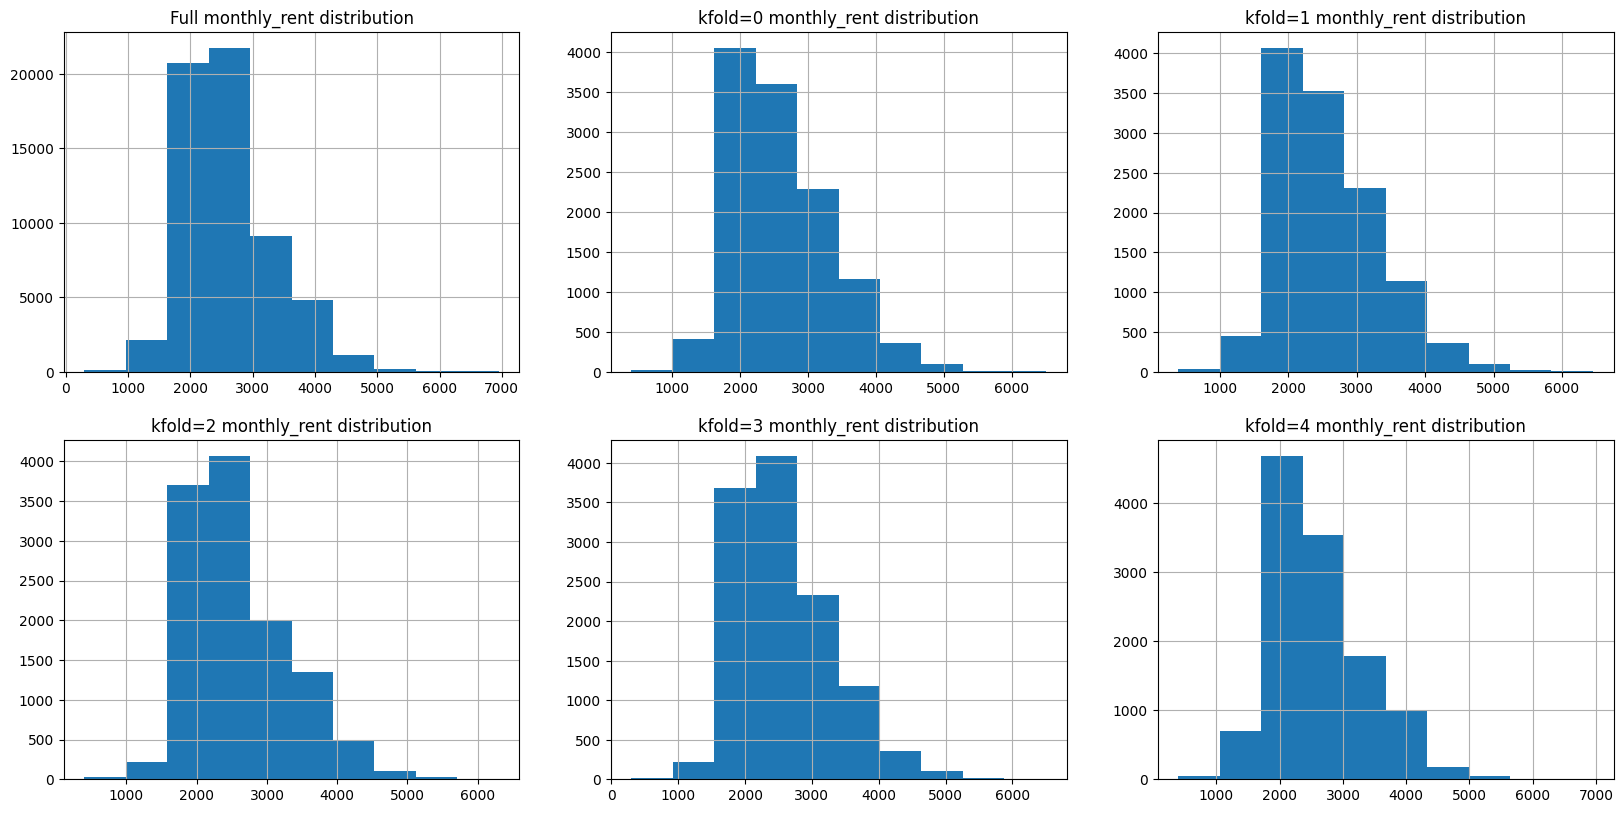

In [ ]:
plt.figure(figsize=(20, 15))
plt.subplot(3,3,1)
df['monthly_rent'].hist()
plt.title('Full monthly_rent distribution')
for i in range(5):    
    plt.subplot(3,3,i+2)
    df[df['kfold'] == i]['monthly_rent'].hist()
    plt.title(f'kfold={i} monthly_rent distribution')